In [1]:
#Yuri Muller PLumm Gomes
#PhD student at CBPF
#yurimullergomes@gmail.com

In [ ]:
import tensorflow as tf
import pickle
import numpy as np
import pandas as pd
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
%matplotlib inline

pickle_in = open("Xaug.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("yaug.pickle","rb")
y0 = pickle.load(pickle_in)

X = np.array(X)/255.0 #normalizing data

y = np.array(y0)



c:\programdata\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
stat_df_x = pd.DataFrame({'X_d': [X[i] for i in range(len(X))] })
stat_df_y = pd.DataFrame({'y_data': y })

df_final_st = pd.concat([stat_df_y,stat_df_x], axis=1)
df_final_st.head()

# Load the model

In [ ]:
new_model = tf.keras.models.load_model('first-puzzle-aug-3cnn-dr.model') #loading the model

# shuffling the data 
# making predictions of the shuffled x_test
# changing the threshold of probability
# counting True positives (tp), fp, tn, fn and evaluating the TPR, FPR rates 

In [5]:
TPR = {}
FPR = {}

df_final_st = df_final_st.sample(frac=1).reset_index(drop=True)  #shuffle the rows only
df = 10
X_u = df_final_st['X_d']
y_u = df_final_st['y_data']
X_test = np.array([X_u[j] for j in range((len(X)//df))])
X_train = np.array([X_u[j] for j in range((len(X)//df),len(X))])#

y_test = np.array([y_u[j] for j in range((len(y)//df))])
y_train = np.array([y_u[j] for j in range((len(y)//df),len(y))])

In [6]:
predictions = new_model.predict(X_test)

In [7]:
df = pd.DataFrame({'y_test': y_test})
y_pred = [np.argmax(predictions[j]) for j in range(len(y_test))]
y_prob = [predictions[j][np.argmax(predictions[j])] for j in range(len(y_test))]

pd_y_test = pd.DataFrame({'y_test':y_test})
pd_y_prob = pd.DataFrame({'y_prob':y_prob})
pd_y_pred = pd.DataFrame({'y_pred':y_pred})

df_final = pd.concat([pd_y_pred, pd_y_test,pd_y_prob], axis=1)

#evaluating the completeness

df_final_0 = df_final[df_final['y_test'] == 0]
df_final_1 = df_final[df_final['y_test'] == 1]
df_final_2 = df_final[df_final['y_test'] == 2]

n0 = df_final_0[df_final_0.y_pred == 0]    # correct predictions for class-0 / threshold=0
n1 = df_final_1[df_final_1.y_pred == 1]    # correct predictions for class-1 / threshold=0
n2 = df_final_2[df_final_2.y_pred == 2]    # correct predictions for class-2 / threshold=0



In [9]:
shift = int(50)
threshold = [j/shift for j in range(shift+1)]
count_0_ROC = []
count_1_ROC = []
count_2_ROC = []
countf_0_ROC = []
countf_1_ROC = []
countf_2_ROC = []
for thr in threshold:
   #count the True positive of class-0,1, and 2 :
    n0tp_ROC = n0[n0.y_prob > thr].count()        
    n1tp_ROC = n1[n1.y_prob > thr].count()        
    n2tp_ROC = n2[n2.y_prob > thr].count()        

    #count the False negative of class-0,1 and 2:
    n0fn_ROC = n0[n0.y_prob < thr].count()              
    n1fn_ROC = n1[n1.y_prob < thr].count()             
    n2fn_ROC = n2[n2.y_prob < thr].count()             

    # false positive for class-0,1 and 2:
    n0fp_ROC = df_final_0[(df_final_0.y_pred != 0) & (df_final_0.y_prob > thr)].count()
    n1fp_ROC = df_final_1[(df_final_1.y_pred != 1) & (df_final_1.y_prob > thr)].count()  
    n2fp_ROC = df_final_2[(df_final_2.y_pred != 2) & (df_final_2.y_prob > thr)].count()  

   # true negative for class-0,1 and 2:
    n0tn_ROC = df_final_0[(df_final_0.y_pred != 0) & (df_final_0.y_prob < thr)].count()
    n1tn_ROC = df_final_1[(df_final_1.y_pred != 1) & (df_final_1.y_prob < thr)].count() 
    n2tn_ROC = df_final_2[(df_final_2.y_pred != 2) & (df_final_2.y_prob < thr)].count() 

   #creating a list with the results for TPR and FPR:
    count_0_ROC.append(n0tp_ROC[0]/(n0tp_ROC[0] + n0fn_ROC[0]))     #TPR = true positive / (true positive + true negative)  
    count_1_ROC.append(n1tp_ROC[0]/(n1tp_ROC[0] + n1fn_ROC[0]))
    count_2_ROC.append(n2tp_ROC[0]/(n2tp_ROC[0] + n2fn_ROC[0]))

    countf_0_ROC.append(n0fp_ROC[0]/(n0tn_ROC[0] + n0fp_ROC[0]))   #FPR = false positive/(false negative + false positive)
    countf_1_ROC.append(n1fp_ROC[0]/(n1tn_ROC[0] + n1fp_ROC[0])) 
    countf_2_ROC.append(n2fp_ROC[0]/(n2fn_ROC[0] + n2fp_ROC[0]))     


    TPR = [count_0_ROC,count_1_ROC,count_2_ROC]
    FPR = [countf_0_ROC,countf_1_ROC,countf_2_ROC]


# saving the resulting TPR and FPR rates

In [10]:
#saving df_final

import pickle

pickle_out = open("TPR_aug_dr.pickle","wb")
pickle.dump(TPR, pickle_out)
pickle_out.close()

pickle_out = open("FPR_aug_dr.pickle","wb")
pickle.dump(FPR, pickle_out)
pickle_out.close()

# Loading the TPR/FPR rates :

In [90]:
import tensorflow as tf
import pickle
import numpy as np
import pandas as pd
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import pickle
%matplotlib inline

pickle_in = open("TPR_aug_dr.pickle","rb")
df_TPR = pickle.load(pickle_in)
pickle_in = open("FPR_aug_dr.pickle","rb")
df_FPR = pickle.load(pickle_in)

In [91]:
Col = ['TPR0','TPR1','TPR2']
Col1 = ['FPR0','FPR1','FPR2']

df_TPR_new = {}
df_FPR_new = {}
for i in range(len(Col)):
    df_TPR_new[i] = df_TPR[i]
    df_FPR_new[i] = df_FPR[i]

df_TPR_tr = pd.DataFrame(df_TPR_new)
df_FPR_tr = pd.DataFrame(df_FPR_new)
#df_TPR.columns = ['TPR'+str(i) for i in range(shift+1)]
#df_FPR.columns = ['FPR'+str(i) for i in range(shift+1)]


In [93]:

#df_TPR_tr = df_TPR.transpose()
#df_FPR_tr = df_FPR.transpose()

df_TPR_tr.head()

,0,1,2
0,1.000000,1.000000,1.000000
1,0.823256,0.755319,0.748159
2,0.759690,0.681611,0.663476
3,0.729457,0.642857,0.611193
4,0.706977,0.606383,0.581738


In [97]:
df_TPR_tr[2][3]

0.6111929307805597

In [98]:
TPR0 = [df_TPR_tr[0][i] for i in range(shift)],[df_TPR_tr[1][i] for i in range(shift)],[df_TPR_tr[2][i] for i in range(shift)]
FPR0 = [df_FPR_tr[0][i] for i in range(shift)],[df_FPR_tr[1][i] for i in range(shift)],[df_FPR_tr[2][i] for i in range(shift)]


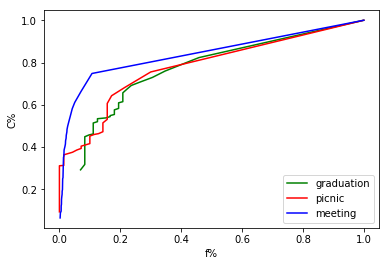

In [100]:
colors = ['g','r','b']
markers = ['graduation','picnic','meeting']
for j in range(len(markers)):
    plt.plot(FPR0[j], TPR0[j],label= markers[j],alpha=1, color = colors[j])
    plt.legend(loc='lower right',fontsize=10)
plt.xlabel('f%')
plt.ylabel('C%')

In [ ]:
# daqui pra baixo está errado

In [1]:
TPR = {}
FPR = {}
for i in range(len(markers)):
    print(i)
    df_final_st = df_final_st.sample(frac=1).reset_index(drop=True)  #shuffle the rows only
    df = 10
    X_u = df_final_st['X_d']
    y_u = df_final_st['y_data']
    X_test = np.array([X_u[j] for j in range((len(X)//df))])
    X_train = np.array([X_u[j] for j in range((len(X)//df),len(X))])#

    y_test = np.array([y_u[j] for j in range((len(y)//df))])
    y_train = np.array([y_u[j] for j in range((len(y)//df),len(y))])

    predictions = new_model.predict(X_test)

    df = pd.DataFrame({'y_test': y_test})
    #creating a array with the predictions
    y_pred = [np.argmax(predictions[j]) for j in range(len(y_test))]
    y_prob = [predictions[j][np.argmax(predictions[j])] for j in range(len(y_test))]

    pd_y_test = pd.DataFrame({'y_test':y_test})
    pd_y_prob = pd.DataFrame({'y_prob':y_prob})
    pd_y_pred = pd.DataFrame({'y_pred':y_pred})

    df_final = pd.concat([pd_y_pred, pd_y_test,pd_y_prob], axis=1)

    #evaluating the completeness

    df_final_0 = df_final[df_final['y_test'] == 0]
    df_final_1 = df_final[df_final['y_test'] == 1]
    df_final_2 = df_final[df_final['y_test'] == 2]

    n0 = df_final_0[df_final_0.y_pred == 0]    # correct predictions for class-0 / threshold=0
    n1 = df_final_1[df_final_1.y_pred == 1]    # correct predictions for class-1 / threshold=0
    n2 = df_final_2[df_final_2.y_pred == 2]    # correct predictions for class-2 / threshold=0

    shift = 20
    threshold = [j/shift for j in range(shift+1)]
    count_0_ROC = []
    count_1_ROC = []
    count_2_ROC = []
    countf_0_ROC = []
    countf_1_ROC = []
    countf_2_ROC = []
    for thr in threshold:
       #count the True positive of class-0,1, and 2 :
        n0tp_ROC = n0[n0.y_prob > thr].count()        
        n1tp_ROC = n1[n1.y_prob > thr].count()        
        n2tp_ROC = n2[n2.y_prob > thr].count()        

        #count the False negative of class-0,1 and 2:
        n0fn_ROC = n0[n0.y_prob < thr].count()              
        n1fn_ROC = n1[n1.y_prob < thr].count()             
        n2fn_ROC = n2[n2.y_prob < thr].count()             

        # false positive for class-0,1 and 2:
        n0fp_ROC = df_final_0[(df_final_0.y_pred != 0) & (df_final_0.y_prob > thr)].count()
        n1fp_ROC = df_final_1[(df_final_1.y_pred != 1) & (df_final_1.y_prob > thr)].count()  
        n2fp_ROC = df_final_2[(df_final_2.y_pred != 2) & (df_final_2.y_prob > thr)].count()  

       # true negative for class-0,1 and 2:
        n0tn_ROC = df_final_0[(df_final_0.y_pred != 0) & (df_final_0.y_prob < thr)].count()
        n1tn_ROC = df_final_1[(df_final_1.y_pred != 1) & (df_final_1.y_prob < thr)].count() 
        n2tn_ROC = df_final_2[(df_final_2.y_pred != 2) & (df_final_2.y_prob < thr)].count() 

       #creating a list with the results for TPR and FPR:
        count_0_ROC.append(n0tp_ROC[0]/(n0tp_ROC[0] + n0fn_ROC[0]))     #TPR = true positive / (true positive + true negative)  
        count_1_ROC.append(n1tp_ROC[0]/(n1tp_ROC[0] + n1fn_ROC[0]))
        count_2_ROC.append(n2tp_ROC[0]/(n2tp_ROC[0] + n2fn_ROC[0]))

        countf_0_ROC.append(n0fp_ROC[0]/(n0tn_ROC[0] + n0fp_ROC[0]))   #FPR = false positive/(false negative + false positive)
        countf_1_ROC.append(n1fp_ROC[0]/(n1tn_ROC[0] + n1fp_ROC[0])) 
        countf_2_ROC.append(n2fp_ROC[0]/(n2tn_ROC[0] + n2fp_ROC[0]))     


        TPR[i] = [count_0_ROC,count_1_ROC,count_2_ROC]
        FPR[i] = [countf_0_ROC,countf_1_ROC,countf_2_ROC]

NameError: name 'markers' is not defined

In [133]:

df_TPR0 = pd.DataFrame(TPR)
df_FPR0 = pd.DataFrame(FPR)

#import pickle

pickle_out = open("TPR_aug_dr.pickle","wb")
pickle.dump(df_TPR0, pickle_out)
pickle_out.close()

pickle_out = open("FPR_aug_dr.pickle","wb")
pickle.dump(df_FPR0, pickle_out)
pickle_out.close()

In [134]:
pickle_in = open("TPR_aug_dr.pickle","rb")
df_TPR = pickle.load(pickle_in)
pickle_in = open("FPR_aug_dr.pickle","rb")
df_FPR = pickle.load(pickle_in)

df_TPR_tr = df_TPR.transpose()
df_FPR_tr = df_FPR.transpose()

In [137]:
#df_TPR_tr[2][0]

In [138]:
TPR_med_0 = [[df_TPR_tr[0][i][j] for i in range(2)] for j in range(10)]
TPR_med_1 = [[df_TPR_tr[1][i][j] for i in range(2)] for j in range(10)]
TPR_med_2 = [[df_TPR_tr[2][i][j] for i in range(2)] for j in range(10)]

FPR_med_0 = [[df_FPR_tr[0][i][j] for i in range(2)] for j in range(10)]
FPR_med_1 = [[df_FPR_tr[1][i][j] for i in range(2)] for j in range(10)]
FPR_med_2 = [[df_FPR_tr[2][i][j] for i in range(2)] for j in range(10)]


# Median: 

In [139]:
#median
TPR_0 =[1/len(TPR_med_0[i])*sum(TPR_med_0[i]) for i in range(int(len(TPR_med_0[i])))]
TPR_1 =[1/len(TPR_med_0[i])*sum(TPR_med_1[i]) for i in range(int(len(TPR_med_0[i])))]
TPR_2 =[1/len(TPR_med_0[i])*sum(TPR_med_2[i]) for i in range(int(len(TPR_med_0[i])))]

FPR_0 =[1/len(FPR_med_0[i])*sum(FPR_med_0[i]) for i in range(int(len(TPR_med_0[i])))]
FPR_1 =[1/len(FPR_med_0[i])*sum(FPR_med_1[i]) for i in range(int(len(TPR_med_0[i])))]
FPR_2 =[1/len(FPR_med_0[i])*sum(FPR_med_2[i]) for i in range(int(len(TPR_med_0[i])))]

TPR=[TPR_0,TPR_1,TPR_2]
FPR=[FPR_0,FPR_1,FPR_2]

# Standard deviation:

In [140]:

TPR_0_std =[np.std(TPR_med_0[i]) for i in range(int(len(TPR_med_0[i])))]
TPR_1_std =[np.std(TPR_med_1[i]) for i in range(int(len(TPR_med_0[i])))]
TPR_2_std =[np.std(TPR_med_2[i]) for i in range(int(len(TPR_med_0[i])))]

FPR_0_std =[np.std(FPR_med_0[i]) for i in range(int(len(TPR_med_0[i])))]
FPR_1_std =[np.std(FPR_med_1[i]) for i in range(int(len(TPR_med_0[i])))]
FPR_2_std =[np.std(FPR_med_2[i]) for i in range(int(len(TPR_med_0[i])))]


TPR_std=[TPR_0_std,TPR_1_std,TPR_2_std]
FPR_std=[FPR_0_std,FPR_1_std,FPR_2_std]

In [141]:
#import seaborn as sns
#sns.set()

# Fit and plots 

In [142]:
from pylab import *
from scipy.optimize import curve_fit

nstd = int(1) # to draw x-sigma intervals
k = 1
def func(x,b,a ):

    return(np.tanh(b*x + a))

x_0 = np.array(FPR[0])
x_1 = np.array(FPR[1])
x_2 = np.array(FPR[2])

y0_0 = np.array(TPR[0])
y0_1 = np.array(TPR[1])
y0_2 = np.array(TPR[2])

noise_0 = np.array(TPR_std[0])
noise_1 = np.array(TPR_std[1])
noise_2 = np.array(TPR_std[2])

y_0 = y0_0 + k*noise_0
y_1 = y0_1 + k*noise_1
y_2 = y0_2 + k*noise_2

Yy = [y_0,y_1,y_2]
Xx = [x_0,x_1,x_2]

popt_0, pcov_0 = curve_fit(func, Xx[0], Yy[0]) # popt = (a,b) pcov = he estimated covariance of popt.
perr_0 = np.sqrt(np.diag(pcov_0))
popt_1, pcov_1 = curve_fit(func, Xx[1], Yy[1]) # ,sigma=1./(noise_1*noise_1)
perr_1 = np.sqrt(np.diag(pcov_1))
popt_2, pcov_2 = curve_fit(func, Xx[2], Yy[2]) # ,sigma=1./(noise_2*noise_2)
perr_2 = np.sqrt(np.diag(pcov_2))



c:\programdata\anaconda3\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [143]:
popt_0

array([11.25987438,  0.33851595])

In [144]:
popt_up_0 = popt_0 + nstd * perr_0
popt_dw_0 = popt_0 - nstd * perr_0

popt_up_1 = popt_1 + nstd * perr_1
popt_dw_1 = popt_1 - nstd * perr_1

popt_up_2 = popt_2 + nstd * perr_2
popt_dw_2 = popt_2 - nstd * perr_2



fit_0 = func(Xx[0], *popt_0)
fit_up_0 = func(Xx[0], *popt_up_0)
fit_dw_0 = func(Xx[0], *popt_dw_0)
fit_1 = func(Xx[1], *popt_1)
fit_up_1 = func(Xx[1], *popt_up_1)
fit_dw_1 = func(Xx[1], *popt_dw_1)
fit_2 = func(Xx[2], *popt_2)
fit_up_2 = func(Xx[2], *popt_up_2)
fit_dw_2 = func(Xx[2], *popt_dw_2)




fit = [fit_0,fit_1,fit_2]
fit_up =[fit_up_0,fit_up_1,fit_up_2] 
fit_dw = [fit_dw_0,fit_dw_1,fit_dw_2]

yerr = nstd*np.array(TPR_std)
xerr = nstd*np.array(FPR_std)

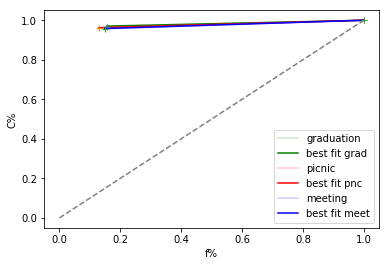

In [146]:
markers = ['graduation','picnic','meeting']
bestfit = ['best fit grad','best fit pnc','best fit meet']
color = ['g','r','b']

x_lin = np.linspace(0, 1, 1000)

fig, ax = plt.subplots()
ax.plot(x_lin, x_lin, '--',color = 'gray')

for j in range(len(markers)):
    plt.plot(FPR[j], TPR[j],label= markers[j],alpha=0.2, color = color[j])
    plt.plot(FPR[j], fit[j],label= bestfit[j],alpha=1,color = color[j])
    plt.legend(loc='lower right',fontsize=10)
    #ax.fill_between(FPR[j], fit_up[j], fit_dw[j], alpha=.25, label= str(nstd)+ '-sigma interval')
    plt.errorbar(FPR[j], TPR[j], yerr = yerr[j], xerr= xerr[j],errorevery=1 , fmt='+', capthick=4)
plt.xlabel('f%')
plt.ylabel('C%')

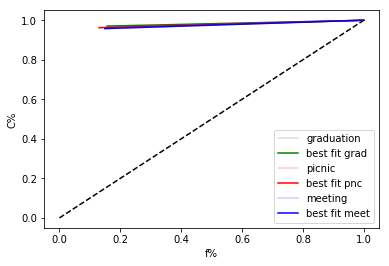

In [147]:
markers = ['graduation','picnic','meeting']
bestfit = ['best fit grad','best fit pnc','best fit meet']
color = ['g','r','b']

x_lin = np.linspace(0, 1, 1000)

fig, ax = plt.subplots()
ax.plot(x_lin, x_lin, '--k')

for j in range(len(markers)):
    plt.plot(FPR[j], TPR[j],label= markers[j], color = color[j],alpha=0.2)
    plt.plot(FPR[j], fit[j],label= bestfit[j],color = color[j])
    #ax.fill_between(FPR[j], fit_up[j], fit_dw[j],alpha=1, label= str(nstd)+ '-sigma interval')
    #errorbar(FPR[j], TPR[j], yerr = yerr[j], xerr= xerr[j] , fmt='+', capthick=4)
plt.legend(loc='lower right',fontsize=10)
plt.xlabel('f%')
plt.ylabel('C%')

In [104]:
from scipy import integrate

AUC_0 = integrate.quad(func, 0, 1,args=(popt_0[0],popt_0[1]))
AUC_1 =integrate.quad(func, 0, 1,args=(popt_1[0],popt_1[1]))
AUC_2 = integrate.quad(func, 0, 1,args=(popt_1[0],popt_1[1]))
print('AUC parameter class 0:',str(AUC_0[0]) + '+-' + str(AUC_0[1]) )
print('AUC parameter class 1:',str(AUC_1[0]) + '+-' + str(AUC_1[1]) )
print('AUC parameter class 2:',str(AUC_2[0]) + '+-' + str(AUC_2[1]) )

AUC parameter class 0: 0.995778916730208+-3.1714147360697635e-12
AUC parameter class 1: 0.993573845770503+-9.762913285373147e-12
AUC parameter class 2: 0.993573845770503+-9.762913285373147e-12


In [98]:
#Overfitting/overtraining in supervised learning (e.g., neural network). If the validation error increases(positive slope) 
#while the training error steadily decreases(negative slope) then a situation of overfitting may have occurred.
#The best predictive and fitted model would be where the validation error has its global minimum.